In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras import datasets, layers, models
import tensorflow as tf
from keras.preprocessing.image import load_img,img_to_array,array_to_img 

from keras.models import load_model

Load Data from Dataset

In [2]:
key_pts_frame = pd.read_csv('/content/drive/MyDrive/P1_Facial_Keypoints-master/data/training_frames_keypoints.csv')  
test_data = pd.read_csv('/content/drive/MyDrive/P1_Facial_Keypoints-master/data/test_frames_keypoints.csv')

In [3]:
train_imgs_name = key_pts_frame.iloc[:,0].values
train_key_pts = key_pts_frame.iloc[:,1:].values.reshape(3462,68,2)
test_imgs_name = test_data.iloc[:,0].values
test_key_pts = test_data.iloc[:,1:].values.reshape(770,68,2)

to Display the images and key points

In [4]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

Convet images to array and Rescale the keypoints to be suitable with new image Size

In [5]:
def load_data(imgs_name,key_pts,path):
  imgs = []
  orignal_imgs = []
  i = 0
  for image_name_ in imgs_name:
    img = load_img(path+image_name_)
    #rescale
    w,h = img.size
    key_pts[i][:,0] = (224/w) * key_pts[i][:,0] #224 is new Size 
    key_pts[i][:,1] = (224/h) * key_pts[i][:,1]
    img = img.resize((224,224))
    orignal_imgs.append(np.array(img)) #imamge on coloerd system
    img = img.convert('L')
    img = np.array(img)
    imgs.append(img)
    i = i+1
  imgs = np.array(imgs)
  orignal_imgs = np.array(orignal_imgs)
  return imgs,key_pts,orignal_imgs


In [6]:

x_test,y_test,test_imgs =  load_data(test_imgs_name,test_key_pts,'/content/drive/MyDrive/P1_Facial_Keypoints-master/data/test/')


In [7]:
x_train,y_train,train_imgs = load_data(train_imgs_name,train_key_pts,'/content/drive/MyDrive/P1_Facial_Keypoints-master/data/training/')

Normalize keypoints to be between 0&1


In [8]:
x_test = x_test.reshape(770,224,224,1)/255.0
x_train = x_train.reshape(3462,224,224,1)/255.0

Normalize keyPoints
mean = 100, sqrt = 50, so, pts should be (pts - 100)/50


In [9]:
y_test = (y_test -100)/50.0
y_train = (y_train -100)/50.0

CNN Architecture
A common architecture for a CNN is a stack of Conv2D and MaxPooling2D layers followed by a few denesly connected layers. To idea is that the stack of convolutional and maxPooling layers extract the features from the image. Then these features are flattened and fed to densly connected layers that determine the class of an image based on the presence of features.


In [10]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#Adding Dense Layers
model.add(layers.Flatten())
model.add(layers.Dense(136))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        3

**Training**
Now we will train and compile the model using the recommended hyper paramaters from tensorflow.


In [14]:
model.compile(optimizer = 'adam',loss = 'mean_squared_error')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
'/content/drive/MyDrive/CSv/face_model', monitor='val_acc', verbose=1, save_best_only=False, mode='max')

history = model.fit(x_train,y_train.reshape(3462,136), epochs=20,batch_size=10,callbacks=[model_checkpoint_callback], 
                    validation_data=(x_test, y_test.reshape(770,136)))

Epoch 1/20
347/347 [==============================] - 202s 580ms/step - loss: 0.0870 - val_loss: 0.0542

Epoch 00001: saving model to /content/drive/MyDrive/CSv/face_model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/CSv/face_model/assets
Epoch 2/20
347/347 [==============================] - 200s 577ms/step - loss: 0.0600 - val_loss: 0.0480

Epoch 00002: saving model to /content/drive/MyDrive/CSv/face_model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/CSv/face_model/assets
Epoch 3/20
347/347 [==============================] - 200s 575ms/step - loss: 0.0537 - val_loss: 0.0328

Epoch 00003: saving model to /content/drive/MyDrive/CSv/face_model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/CSv/face_model/assets
Epoch 4/20
347/347 [==============================] - 200s 577ms/step - loss: 0.0316 - val_loss: 0.0199

Epoch 00004: saving model to /content/drive/MyDrive/CSv/face_model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/CSv/face_model

In [23]:
model = load_model('/content/drive/MyDrive/CSv/thelast') #this is same Model but With 50 Epochs

In [24]:
predictions = model.predict(x_test.reshape(770,224,224,1))


In [25]:
p = (predictions*50)+100 #unnormalize

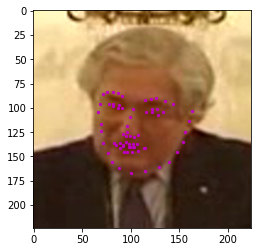

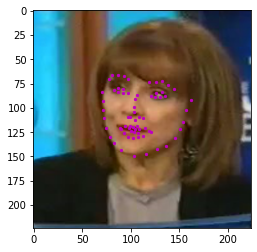

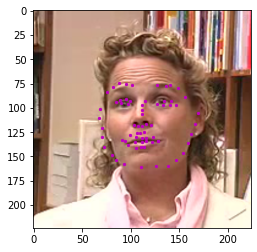

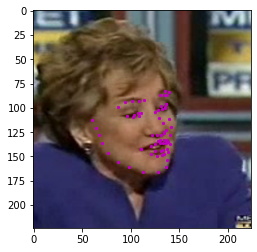

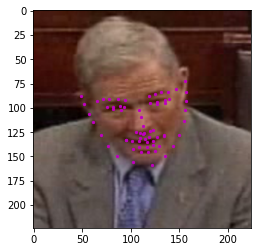

In [28]:
for i in range(0,5):
  show_keypoints(test_imgs[i],p[i].reshape(68,2))
  plt.show()